In [71]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dtc-zoomcamp-qa-challenge/test_questions.csv
/kaggle/input/dtc-zoomcamp-qa-challenge/train_answers.csv
/kaggle/input/dtc-zoomcamp-qa-challenge/sample_submission (1).csv
/kaggle/input/dtc-zoomcamp-qa-challenge/test_answers.csv
/kaggle/input/dtc-zoomcamp-qa-challenge/train_questions.csv
/kaggle/input/dtc-zoomcamp-qa-challenge/attachments/892123_qa7_ml_zoomcamp_office_hours__week_9_pic1.jpg
/kaggle/input/dtc-zoomcamp-qa-challenge/attachments/568107_qa4_01.jpg
/kaggle/input/dtc-zoomcamp-qa-challenge/attachments/322580_qa2_ml_zoomcamp_office_hours__week_5_pic1.jpg
/kaggle/input/dtc-zoomcamp-qa-challenge/attachments/54328_qa6_09.jpg
/kaggle/input/dtc-zoomcamp-qa-challenge/attachments/559148_qa4_02.jpg
/kaggle/input/dtc-zoomcamp-qa-challenge/attachments/121034_qa6_07.jpg
/kaggle/input/dtc-zoomcamp-qa-challenge/attachments/567302_qa2_ml_zoomcamp_office_hours__week_5_pic6.jpg
/kaggle/input/dtc-zoomcamp-qa-challenge/attachments/866867_qa6_08.jpg
/kaggle/input/dtc-zoomcamp-qa-challe

In [72]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Available device: {device}")

Available device: cpu


In [74]:
data_path = '/kaggle/input/dtc-zoomcamp-qa-challenge/'
train_questions_df = pd.read_csv(f'{data_path}/train_questions.csv')
train_answers_df = pd.read_csv(f'{data_path}/train_answers.csv')
test_questions_df = pd.read_csv(f'{data_path}/test_questions.csv')
test_answers_df = pd.read_csv(f'{data_path}/test_answers.csv')

In [75]:
train_questions_df.head()

,question_id,question,course,year,candidate_answers,answer_id
0,79062,"For categorical target set, where the distribu...",Machine Learning Zoomcamp,2021,"156400,754877,105368,643810,912439",156400
1,468946,Is there anything that we are not allowed to u...,Machine Learning Zoomcamp,2021,"641330,634887,912439,425941,642829",634887
2,968800,I have been catching up and have been doing ho...,Data Engineering Zoomcamp,2022,"954016,167856,75919,36798,838013",954016
3,688404,Could you please explain what code we should l...,Data Engineering Zoomcamp,2022,"198661,629898,686577,3699,141765",3699
4,63921,Is it just me or does the model have really ba...,Machine Learning Zoomcamp,2021,"754877,604487,912439,858915,425941",858915


In [76]:
train_answers_df.head()

,answer_id,answer,course,year,attachments_files
0,156400,Alexey\nShould we use something non-standard t...,Machine Learning Zoomcamp,2021,NaN
1,634887,"No, I don't think there is anything you cannot...",Machine Learning Zoomcamp,2021,NaN
2,954016,"Alexey\nYes, you will be. You can submit the p...",Data Engineering Zoomcamp,2022,NaN
3,3699,Alexey\nI think the question refers to the hom...,Data Engineering Zoomcamp,2022,NaN
4,858915,"Dmitry\nIt's fine, because this is the showcas...",Machine Learning Zoomcamp,2021,NaN


In [77]:
test_questions_df.head()

,question_id,question,course,year,candidate_answers
0,707,How much of an effort would it be to use AWS i...,Data Engineering Zoomcamp,2023,"336232,337669,258304,47681,767296"
1,534450,Can you talk about linear regression and regul...,Machine Learning Zoomcamp,2022,"231208,282072,86769,573165,138373"
2,996163,Can you please explain the Python Black setup ...,Data Engineering Zoomcamp,2023,"571892,816559,47681,337669,336232"
3,860215,How many portfolio projects apart from the cou...,Machine Learning Zoomcamp,2022,"643931,988549,918931,235894,608866"
4,980124,Can you talk more about the final project? Wha...,Data Engineering Zoomcamp,2023,"384381,337669,258304,47681,747722"


In [78]:
test_answers_df.head()

,answer_id,answer,course,year,attachments_files
0,767296,Alexey\nProbably more than you want to put in....,Data Engineering Zoomcamp,2023,NaN
1,573165,"Yes, I can. There is actually an entire module...",Machine Learning Zoomcamp,2022,NaN
2,571892,Jeff\nI can try. I like Black a lot. If you ju...,Data Engineering Zoomcamp,2023,NaN
3,988549,"Again, you’ll probably hate me soon for saying...",Machine Learning Zoomcamp,2022,NaN
4,384381,Alexey\nThe first thing about the dataset – wh...,Data Engineering Zoomcamp,2023,NaN


In [79]:
# Let's marge the train questions and answers in one dataframe
train_merged_df = pd.merge(
    train_questions_df, train_answers_df, on='answer_id', how='inner', suffixes=('_question', '_answer')
)
train_merged_df = train_merged_df.drop_duplicates()
train_merged_df.shape

(397, 10)

In [80]:
train_merged_df.head()

,question_id,question,course_question,year_question,candidate_answers,answer_id,answer,course_answer,year_answer,attachments_files
0,79062,"For categorical target set, where the distribu...",Machine Learning Zoomcamp,2021,"156400,754877,105368,643810,912439",156400,Alexey\nShould we use something non-standard t...,Machine Learning Zoomcamp,2021,NaN
1,468946,Is there anything that we are not allowed to u...,Machine Learning Zoomcamp,2021,"641330,634887,912439,425941,642829",634887,"No, I don't think there is anything you cannot...",Machine Learning Zoomcamp,2021,NaN
2,968800,I have been catching up and have been doing ho...,Data Engineering Zoomcamp,2022,"954016,167856,75919,36798,838013",954016,"Alexey\nYes, you will be. You can submit the p...",Data Engineering Zoomcamp,2022,NaN
3,688404,Could you please explain what code we should l...,Data Engineering Zoomcamp,2022,"198661,629898,686577,3699,141765",3699,Alexey\nI think the question refers to the hom...,Data Engineering Zoomcamp,2022,NaN
4,63921,Is it just me or does the model have really ba...,Machine Learning Zoomcamp,2021,"754877,604487,912439,858915,425941",858915,"Dmitry\nIt's fine, because this is the showcas...",Machine Learning Zoomcamp,2021,NaN


(array([191., 153.,  90.,  42.,  17.,  12.,   7.,   1.,   1.,   2.]),
 array([3.000e+00, 4.530e+02, 9.030e+02, 1.353e+03, 1.803e+03, 2.253e+03,
        2.703e+03, 3.153e+03, 3.603e+03, 4.053e+03, 4.503e+03]),
 <BarContainer object of 10 artists>)

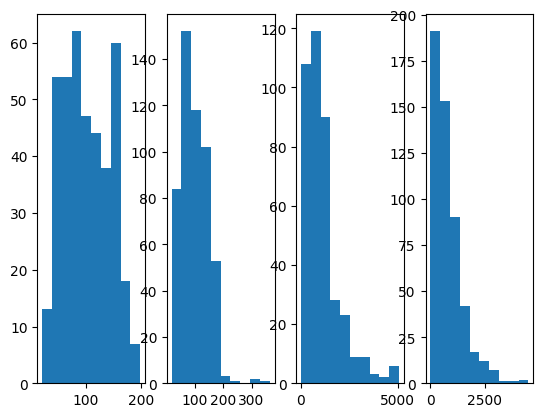

In [81]:
n_bins = 10

fig, axs = plt.subplots(1, 4)
axs[0].hist(list(map(len,train_questions_df['question'])), bins=n_bins)
axs[1].hist(list(map(len,test_questions_df['question'])), bins=n_bins)
axs[2].hist(list(map(len,train_answers_df['answer'])), bins=n_bins)
axs[3].hist(list(map(len,test_answers_df['answer'])), bins=n_bins)

In [82]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
model.to(device) 

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [83]:
def get_bert_embeddings(text):
    """
    Function for getting text embeddings using BERT
    Returns one embedding as an average of the words embeddings of the text 
    """
    tokens = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    tokens = {key: value.to(device) for key, value in tokens.items()}
    with torch.no_grad():
        outputs = model(**tokens)
    return outputs['last_hidden_state'][0].mean(dim=0).cpu().numpy()

In [84]:
# train_question_embeddings = train_merged_df['question'].apply(get_bert_embeddings)
# train_answer_embeddings = train_merged_df['answer'].apply(get_bert_embeddings)

In [85]:
scaler = StandardScaler()
train_question_embeddings_standardized = scaler.fit_transform(np.array(train_question_embeddings.tolist()))
train_answer_embeddings_standardized = scaler.transform(np.array(train_answer_embeddings.tolist()))

In [86]:
train_question_embeddings_standardized

array([[-0.84950286, -1.8066208 , -0.715403  , ...,  1.4738399 ,
        -1.0824224 ,  0.5299448 ],
       [ 0.5119831 , -0.8512656 ,  0.52832526, ..., -0.02905224,
        -1.028258  , -0.27570087],
       [ 1.2593473 , -0.46004006,  0.43172395, ...,  2.627582  ,
         1.101011  , -1.7561183 ],
       ...,
       [-0.6851817 , -0.15996689, -1.1206119 , ...,  1.5289718 ,
        -0.4282645 , -0.1155218 ],
       [ 0.31283152, -1.3003436 , -1.4371535 , ...,  0.96968997,
         1.2367498 , -0.6089649 ],
       [-0.00846126,  0.03815083, -0.759278  , ...,  0.08501945,
        -0.1037942 , -0.2763848 ]], dtype=float32)

In [87]:
def get_predictions(df_questions, df_answers):
    """
    Function that finds the best answer to each question according to their similarity.
    """
    predicted_answers = []
    predicted_answer_ids = []

    for index, row in df_questions.iterrows():
        question_text = row['question'].lower()
        candidate_answer_ids = [int(answer_id) for answer_id in row['candidate_answers'].split(",")]

        # Getting questions embeddings
        question_embedding = get_bert_embeddings(question_text)
        question_embedding_standardized = scaler.transform(question_embedding.reshape(1, -1))

        # Getting answer candidate embeddings
        candidate_answers_df = df_answers[df_answers['answer_id'].isin(candidate_answer_ids)]
        candidate_answer_embeddings = candidate_answers_df['answer'].apply(get_bert_embeddings)
        candidate_answer_embeddings_standardized = scaler.transform(np.array(candidate_answer_embeddings.tolist()))

        # Calculating similarity between question and answers embeddings
        similarities = cosine_similarity(question_embedding_standardized, candidate_answer_embeddings_standardized).flatten()

        # Taking index of the best answer candidate
        best_answer_index = similarities.argmax()

        predicted_answer = candidate_answers_df.iloc[best_answer_index]['answer']
        predicted_answer_id = candidate_answers_df.iloc[best_answer_index]['answer_id']
        predicted_answers.append(predicted_answer)
        predicted_answer_ids.append(predicted_answer_id)
        
    return predicted_answer_ids, predicted_answers

In [88]:
# train_predictions_df = pd.DataFrame({
#     'question_id': train_questions_df['question_id'],     
#     'question': train_questions_df['question'],
#     'candidate_answers': train_questions_df['candidate_answers'],
#     'answer_id': train_questions_df['answer_id'],
# })

In [89]:
# train_predictions_df['predicted_answer_id'], train_predictions_df['predicted_answer'] = \
#     get_predictions(train_questions_df, train_answers_df)

In [90]:
# train_predictions_df.head()

In [91]:
# accuracy = (train_predictions_df['predicted_answer'] == train_answers_df['answer']).mean()
# print(f'Accuracy: {accuracy:.4f}')

In [92]:
# test_questions_df = test_questions_df.drop_duplicates(subset='question_id')
# test_questions_df.shape

In [93]:
# test_predictions_df = pd.DataFrame({
#     'question_id': test_questions_df['question_id'], 
# })
# test_predictions_df['predicted_answer_id'], test_predictions_df['predicted_answer'] = \
#     get_predictions(test_questions_df, test_answers_df)

In [94]:
# test_predictions_df[['question_id', 'predicted_answer_id']].to_csv('BERT_sample_submission.csv', index=False)

In [133]:
class TextSet(Dataset):
    def __init__(self,train_merged_df):
        self.train_merged_df = train_merged_df
        model_name = 'bert-base-uncased'
        tokenizer = BertTokenizer.from_pretrained(model_name)
    def __get_tokens(self,X):
        tokens = tokenizer(X, return_tensors='pt', truncation=True, padding='max_length', max_length=128)
        tokens = {key: value.to(device) for key, value in tokens.items()}
        return tokens
    def __len__(self):
        return len(self.train_merged_df)
    def __getitem__(self, idx):
        x = self.train_merged_df['question'].loc[idx]
        y = self.train_merged_df['answer'].loc[idx]
        return self.__get_tokens(x), self.__get_tokens(y)

        

In [134]:
text_set = TextSet(train_merged_df)

In [135]:
text_set[9]

({'input_ids': tensor([[  101,  2129,  1005,  1055,  5464,  2367,  2013,  1996, 26237,  2944,
            1029,   102,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               

In [98]:
dataloader = DataLoader(text_set, batch_size=16,
                        shuffle=True, num_workers=0)

In [102]:
class BertForSTS(torch.nn.Module):

    def __init__(self):
        super(BertForSTS, self).__init__()
        self.pooling_layer = models.Pooling(self.bert.get_word_embedding_dimension())
        self.sts_bert = BertModel()

    def forward(self, input_data):
        outputs = self.sts_bert(input_data)
        return outputs['last_hidden_state'][0].mean(dim=0).cpu().numpy()

In [100]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [105]:
for step, (text_1,text_2) in enumerate(dataloader):
    predicted_1 = model(text_1)
    predicted_2 = model(text_2)
    loss = cosine_similarity(predicted_1,predicted_2).flatten()
    

RuntimeError: The expanded size of the tensor (768) must match the existing size (512) at non-singleton dimension 1.  Target sizes: [16, 768].  Tensor sizes: [1, 512]